In [1]:
import os
import sys

# Importante, serve a fare in modo che il jupyter notebook possa vedere ed importare i file di libreria che creiamo in questa cartella.
sys.path.insert(0, '..')

In [2]:
# Pandas
import pandas as pd

# Valutatore del modello
import functions.evaluation as evaluation

# Funzioni di caricamento dati
import functions.load as load

# Modello da testare
from sklearn.neighbors import KNeighborsRegressor

# Bagging e Boosting
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor

In [3]:
# Carico il dataset (utilizziamo quello con meno features)
df = pd.read_csv(r'../data/ridge_features_refined_data.csv')
df

,Lot_Area,Overall_Qual,Overall_Cond,Mas_Vnr_Area,Exter_Qual,Bsmt_Qual,Bsmt_Exposure,BsmtFin_Type_1,Bsmt_Unf_SF,Total_Bsmt_SF,...,Central_Air_N,Central_Air_Y,Garage_Type_Basment,Garage_Type_BuiltIn,Garage_Type_Detchd,Garage_Type_No_Garage,Sale_Type_'WD ',Year_Sold,Mo_Sold,Sale_Price
0,-2.125439,7,5,0.292336,3,4,3,6,0.799868,0.339314,...,0,1,0,0,0,0,0,2006,3,0.015387
1,-2.123480,7,5,1.114337,3,4,4,6,0.847019,0.412956,...,0,1,0,0,0,0,1,2006,4,0.614236
2,-2.007543,8,5,0.628858,3,4,4,1,0.817310,0.356023,...,0,1,0,0,0,0,1,2006,5,0.631522
3,-2.173043,7,5,0.628858,3,4,3,6,0.098655,0.416660,...,0,1,0,0,0,0,1,2006,5,0.971735
4,-2.085350,7,5,0.334853,3,4,1,1,0.858377,0.420960,...,0,1,0,0,0,0,1,2006,5,0.178497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,1.028198,8,5,-0.790677,3,4,1,6,0.291247,0.347376,...,0,1,0,0,0,0,1,2008,12,0.956894
2923,0.155339,8,5,1.236544,3,3,1,1,0.190202,-0.635578,...,0,1,0,0,0,0,1,2009,1,0.202529
2924,1.119751,8,8,1.026412,3,4,4,5,-0.197325,0.742559,...,0,1,0,0,0,0,1,2009,4,1.235211
2925,0.992519,8,9,1.545469,4,4,4,6,0.058520,0.596752,...,0,1,0,0,0,0,1,2009,6,1.597317


# K-Nearest-Neighbor

Facciamo tuning dei parametri per ottenere un modello performante:

In [4]:
# Crea il modello di regressione basato su kNN
model = KNeighborsRegressor(n_jobs = 4)

# Definisco la griglia di iperparametri da provare
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'p': range(1, 5)
}

In [5]:
# Crea l'Evaluator per valutare il modello
ev = evaluation.Evaluator(model = model, df = df, ylabel = 'Sale_Price')

In [6]:
# Trova quali sono i parametri migliori per il modello
best_params, best_score = ev.grid_search_cv(params=param_grid)
load.saveBestParameterModel(type(ev.model).__name__,best_params)

best_params, best_score

({'n_neighbors': 5,
  'p': 1,
  'weights': 'distance',
  'model_name': 'KNeighborsRegressor'},
 0.8661864820335416)

In [7]:
# Inseriamole in delle variabili per poterle usare con più semplicità
k = best_params['n_neighbors']
p = best_params['p']
w = best_params['weights']

Creiamo il modello con i parametri trovati:

In [8]:
# Costruisci il regressore basato su kNN con i migliori parametri trovati
kNN = KNeighborsRegressor(n_neighbors = k, weights = w, p = p, n_jobs = 4)
kNN

KNeighborsRegressor(n_jobs=4, p=1, weights='distance')

In [9]:
# Creiamo l'Evaluator per valutare il modello con i parametri trovati
ev = evaluation.Evaluator(model = kNN, df = df, ylabel = 'Sale_Price')

# Fa splittare il dataset passato al valutatore (test_size = 0.20 di default)
ev.split_dataset(test_size=0.33)

In [10]:
# Valutiamo il modello secondo un Cross-Validation temporale
ev.temporal_cv(verbose=True).inline()

[Split 0/10] - train_size: 0.092
r2: 0.81609  -  explained_variance: 0.82943  -  rmse: 0.38973  -  mae: 0.22799  -  max_error: 1.94292

[Split 1/10] - train_size: 0.183
r2: 0.87482  -  explained_variance: 0.87987  -  rmse: 0.35964  -  mae: 0.16660  -  max_error: 1.16982

[Split 2/10] - train_size: 0.274
r2: 0.80714  -  explained_variance: 0.80714  -  rmse: 0.47421  -  mae: 0.23617  -  max_error: 2.64902

[Split 3/10] - train_size: 0.365
r2: 0.85820  -  explained_variance: 0.86215  -  rmse: 0.34732  -  mae: 0.19339  -  max_error: 1.11150

[Split 4/10] - train_size: 0.455
r2: 0.88492  -  explained_variance: 0.88943  -  rmse: 0.30098  -  mae: 0.17720  -  max_error: 1.03656

[Split 5/10] - train_size: 0.546
r2: 0.82892  -  explained_variance: 0.82994  -  rmse: 0.41656  -  mae: 0.18285  -  max_error: 1.98551

[Split 6/10] - train_size: 0.637
r2: 0.81724  -  explained_variance: 0.81732  -  rmse: 0.48033  -  mae: 0.20324  -  max_error: 3.85775

[Split 7/10] - train_size: 0.728
r2: 0.86229  - 

'r2: 0.84796  -  explained_variance: 0.85115  -  rmse: 0.38296  -  mae: 0.19247  -  max_error: 1.86696'


Valutiamo il modello sul test set:

In [11]:
# Valutiamo il modello sul test set
ev.evaluate()

r2:                  0.84538
explained_variance:  0.84557
rmse:                0.39721
mae:                 0.17411
max_error:           4.29665

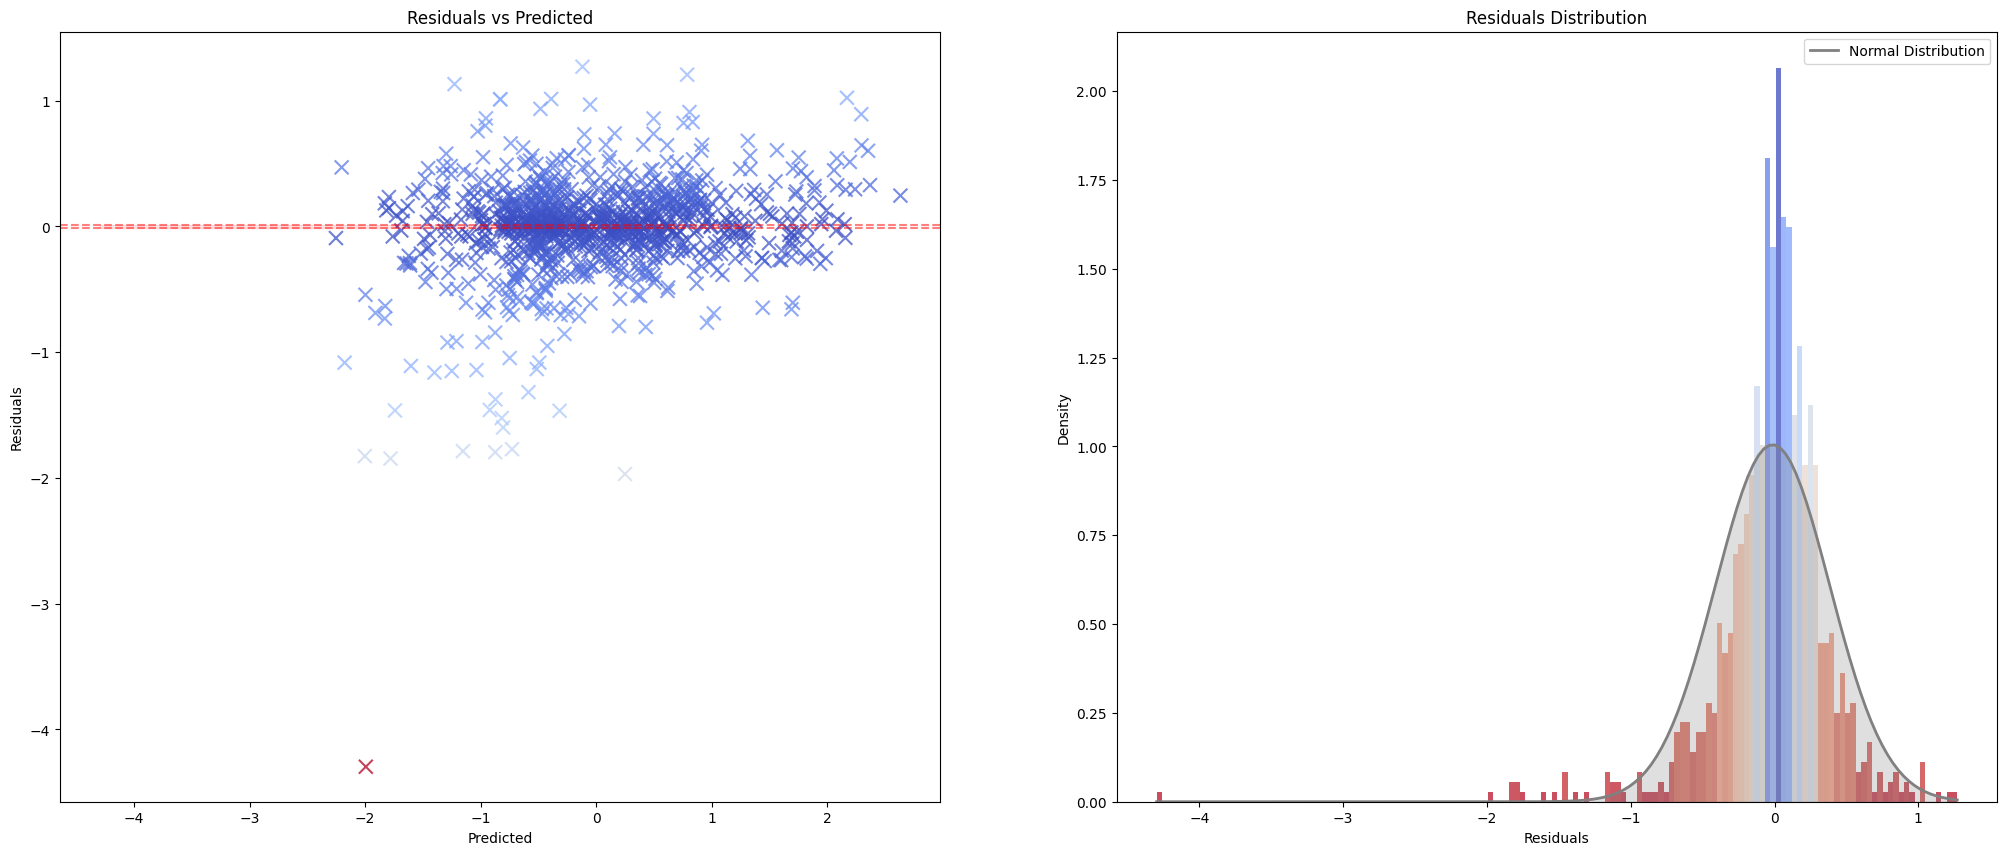

In [12]:
# Visualizziamo i residui e la loro distribuzione
ev.plot_residuals()

# Ensembling con il kNN

## Boosting

In [13]:
# Istanziamo il nostro Ensembler che utilizzera come Weak Learner il nostro kNN
adaboost = AdaBoostRegressor(kNN, n_estimators = 200)
adaboost

AdaBoostRegressor(estimator=KNeighborsRegressor(n_jobs=4, p=1,
                                                weights='distance'),
                  n_estimators=200)

In [14]:
# Creiamo l'Evaluator per valutare il modello
ev = evaluation.Evaluator(model = adaboost, df = df, ylabel = 'Sale_Price')

# Valutiamo il modello sul test set
ev.evaluate()

r2:                  0.85836
explained_variance:  0.85902
rmse:                0.38034
mae:                 0.16420
max_error:           4.01685

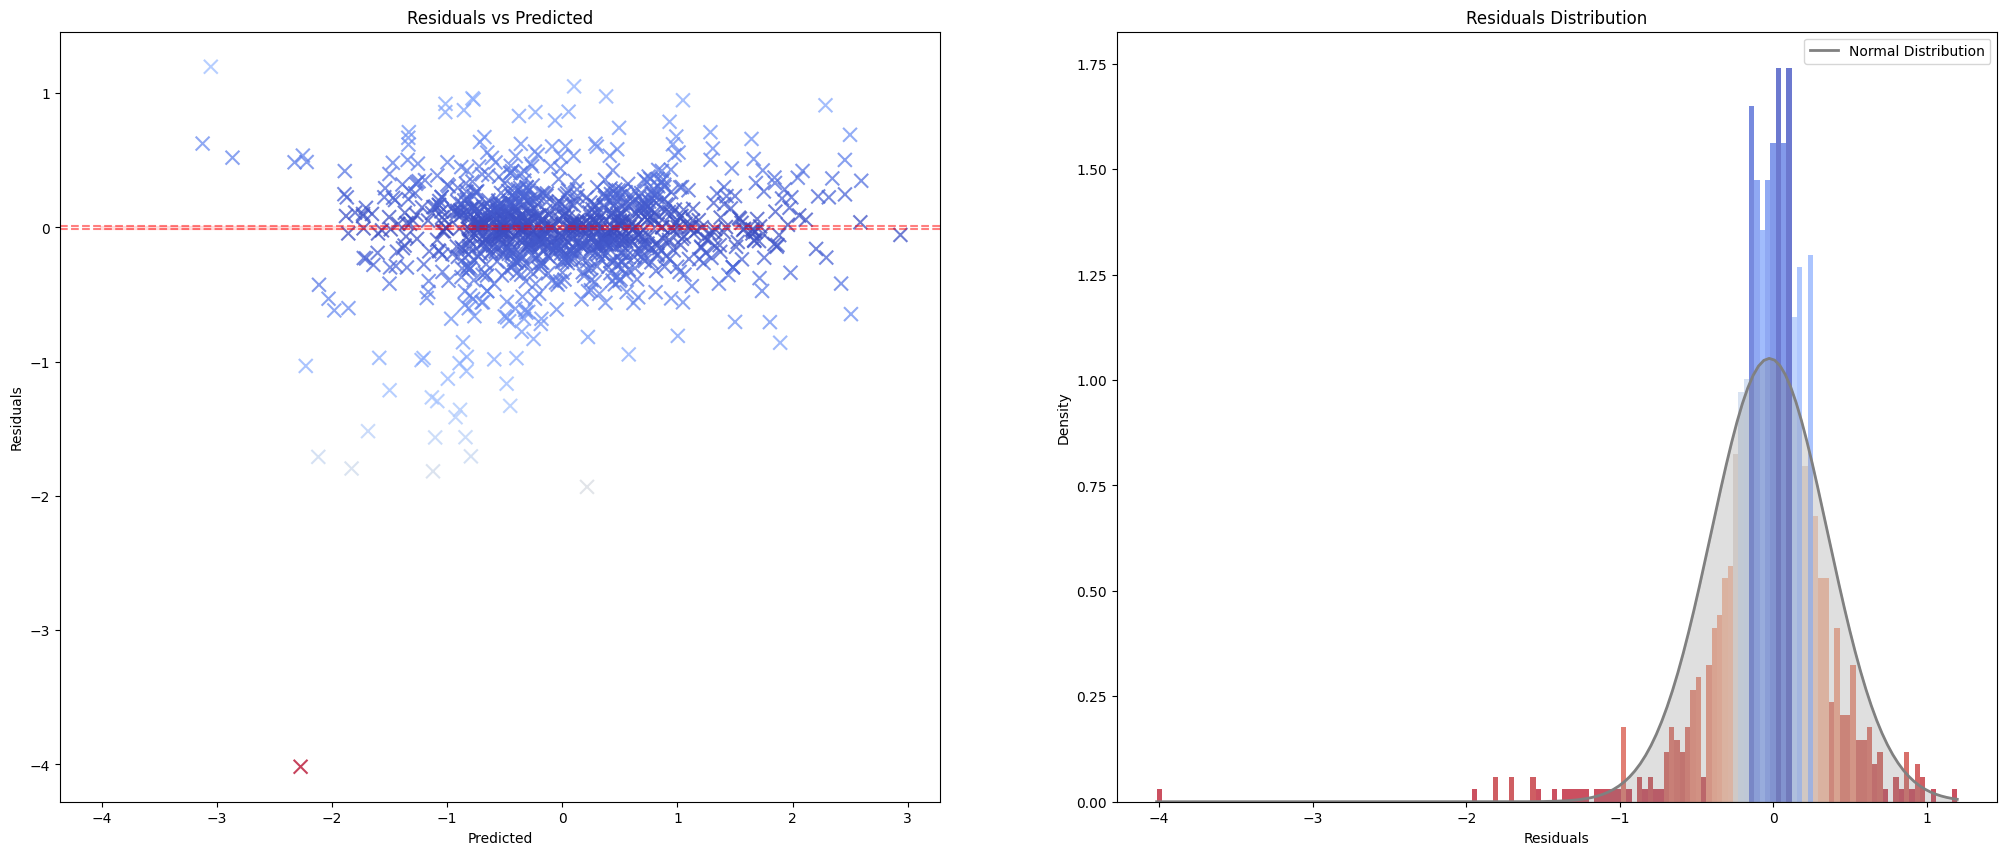

In [15]:
ev.plot_residuals()

## Bagging

In [16]:
bagged_knn = BaggingRegressor(kNN, n_estimators = 200)
bagged_knn

BaggingRegressor(estimator=KNeighborsRegressor(n_jobs=4, p=1,
                                               weights='distance'),
                 n_estimators=200)

In [17]:
# Creiamo l'Evaluator per valutare il modello
ev = evaluation.Evaluator(model = bagged_knn, df = df, ylabel = 'Sale_Price')

# Valutiamo il modello sul test set
ev.evaluate()

r2:                  0.84997
explained_variance:  0.85028
rmse:                0.39145
mae:                 0.16570
max_error:           4.29138

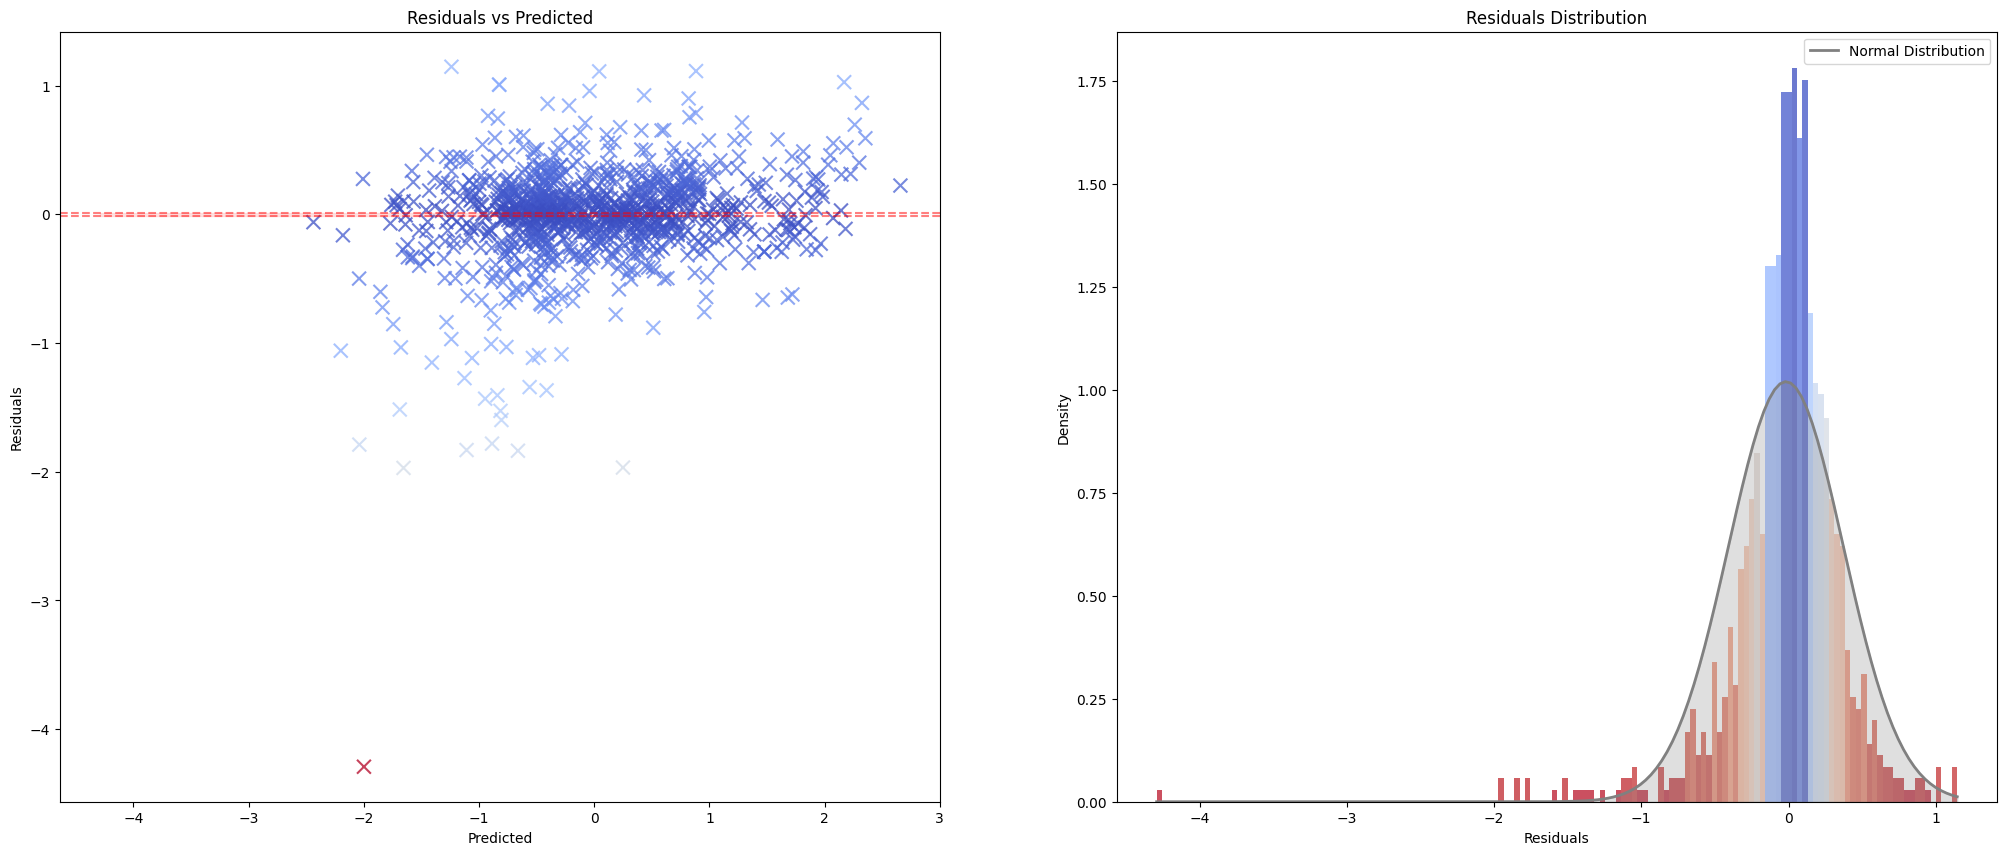

In [18]:
# Visualizziamo i residui e la loro distribuzione
ev.plot_residuals()